In [12]:
# NLP imports
import nltk
from nltk.stem import WordNetLemmatizer

# Regular imports
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime

# Scraping imports
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, unquote

# Graph imports
import re
import pickle
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain

# Statistic imports
import powerlaw
import scipy.stats as ss

# Web Scrabing
### Getting the html content of each page

To get the data from our source Heste-nettet.dk, we setup a webcrawler using the bingbot agent as listed below in the header variable.

This is wrapped into a HTML context handler that is given a url and then scrapes the context name. If the name exist locally on the machine, it uses the path to the file locally, otherwise it download the HMTL content from its target.

This was done so we only needed to scrape the entire webpage once, as this took about 18 hours on the first run, but concurrently we could load all approximate 180.000 posts in a hour.

In [3]:
# Bingbot header
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"} 

# HTML context handler. To prevent DDOS of targetm,
# as well as speedup concurrent runs, it stores the html content locally,
# and reads from there if the queried files are available.
def get_html_content(url, save_dir):
    # Parse the URL to get the path
    parsed_url = urlparse(url)
    # Decode any percent-encoded characters in the path
    path = unquote(parsed_url.path)
    
    # Remove the leading and trailing slashes and replace remaining slashes with underscores
    filename = path.strip('/').replace('/', '_') + '.html'
    
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Define the path for the file
    file_path = os.path.join(save_dir, filename)

    # Check if the file already exists
    if not os.path.isfile(file_path):
        # If not, make a request and save the file
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(response.text)
            soup = BeautifulSoup(response.text, "html.parser")
            return soup
        elif response.status_code in [404, 403]:
            print(f"Response code: {response.status_code} for {url}")
        else:
            return None
    else:
        # If the file exists, read it from the disk
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        soup = BeautifulSoup(content, "html.parser")
        return soup


### Getting the text from HTML content

The author text scraper is built by inspecting the HTML elements of the webpage and selecting the elements of interest to filter toward with beatiful soup.

The rsPost elements are each a text field on a post.

In [4]:

# function for scraping the relevant text elements from the hestenettet specific HTML architecture
def author_text_scrape(soup):
    author_list = []
    text_list = []
    # Find all the <td> elements with class "light" and itemprop="text"
    td_elements = soup.find_all('td', bgcolor='#787878', valign='top')

    # Iterate through the <td> elements
    for td in td_elements:
        # Extract the author's href number
        author_a = td.find('a', itemprop='url')
        if author_a:
            author_href = author_a['href']
            author_text = author_a.text
            
        else:
            author_href = None
            author_text = td.find('span', itemprop='name').text
        # print(author_text)
        # Find the first <div> with class "rsPost" within the current <td>
        rs_post = td.find('div', class_='rsPost')
        
        if rs_post:
            # Extract Danish text within <span> tags
            danish_text = [span.text for span in rs_post.find_all('p')]
            
            # Combine the text into a single string
            danish_text = "\n".join(danish_text)
            author_list.append(author_text)
            text_list.append(danish_text)


    return author_list, text_list


### Finding timestamps from HTML content

We scrape the timestamps and subject tags by again using HTML inpsection to pick out the patterns in the HMTL structure. Here we find the light_tds to contain times and the 2nd b_element in each tr element to contain the subject tags.

In [5]:

# Helper function to extract timestamps and tags of hestenettet posts using BS4
date_format = "%d-%m-%y %H:%M"
def extract_timestamp_and_tag_of_post(soup):
    rows = soup.find_all('tr', {'valign': 'middle'})

    for row in rows:
        # Find all <td> elements with class 'light' within each row
        light_tds = row.find_all('td', class_='light')
        b_element = light_tds[1].find('span').find('b')
        tag = b_element.text
        # Select the last <td> element if it exists
        if light_tds:
            last_light_td = light_tds[-1]
            # Do something with last_light_td, e.g., print it
            return datetime.strptime(last_light_td.text,date_format),tag
       

### Wrapper function to run through all the main pages

Finally we combine the above functions into the first of 2 scraping loops that iterates over all index pages of Heste-nettet to get the url's for all individual posts. A benefit here is that each index page contains 70 posts, so we can iterate over a predefined range, but the urls of the posts themselves are random.

In [ ]:
 
html_dir = './html_scrape' # local dir for downloaded html elements
# Very inefficient list containers
href_list = []
post_title_list = []
timestamp_list = []
post_tag_list = []
# Specify the amount of post wanted
amount_of_post = int(10500/2+1) #for all available data use: int(# 185780+1) 

# Loops through the index pages of Hyggesnak and collects all the subpage adresses,
# as well as metadata for post node attributes.
for page_index in tqdm(range(70,amount_of_post,70)): 
    soup = get_html_content(f"https://www.heste-nettet.dk/forum/1/{page_index}/",html_dir)
    post_links = soup.find_all("a",href=True)
    timestamp,post_tag = extract_timestamp_and_tag_of_post(soup)

    # Filter  links
    for link in post_links:
        href = link['href']
        if "/forum/1/" in href and len(href.split("/"))==6:
            href_list.append(href)
            post_title_list.append(link.text)
            timestamp_list.append(timestamp)
            post_tag_list.append(post_tag)

### Wrapper function to run through all posts in each main page

Having scraped all post urls we scrape through these to fetch all their content according to the filter set in author_text_scrape. Then we store all the extracted elements, that actually contain data into lists for later use.

In [ ]:
# Another unnecesarily inefficient list storage architecture
authors_data = []
texts_data = []
used_href_list = []
used_titles_list = []
used_timestamps_list = []
used_tag_list = []
# Loops through all the collected page adresses and scrapes the text and authors using the helper function
for idx,href in enumerate(tqdm(href_list)):
    url = f"https://www.heste-nettet.dk{href}"
    if (soup:=get_html_content(url,html_dir)):
        author_list, text_list = author_text_scrape(soup)
        if len(author_list)>0 and len(text_list)>0:
            authors_data.append(author_list)
            texts_data.append(text_list)
            used_href_list.append(href)
            used_titles_list.append(post_title_list[idx])
            used_timestamps_list.append(timestamp_list[idx])
            used_tag_list.append(post_tag_list[idx])

100%|██████████| 5250/5250 [31:00<00:00,  2.82it/s]


### Finally cleaning the text

To later use the text from the posts we want to store it into a graph in a proper format. Thus we setup a text formatter, that removes HTML elements from the text. Likewise we can both concatenate text for posts, or simply clean the text for users.

In [ ]:
# Helper function to prepare the text for node attributes.
def clean_and_concatenate(data):
    # Remove empty strings
    data = [s for s in data if s.strip()]

    # Normalize whitespace and replace non-breaking spaces
    cleaned_data = [re.sub(r'\s+', ' ', s.replace('\xa0', ' ')).strip() for s in data]

    # Concatenate the strings into a single text
    concatenated_text = ' '.join(cleaned_data)
    return concatenated_text

def clean_string(s):
    return re.sub(r'\s+', ' ', s.replace('\xa0', ' ')).strip()

# Creating the graph
### The total graph

The graph generation is simple. We take all of the collected data and iterate over each collected post. This allows us to aggreate data to the posts and associated users, post by post. Then we model the graph using the bipartite attribute for later projections.

For the users, we concatenate all the text they have written on each post, to their own indivudal node, as well as the post they wrote it on.

In [ ]:
# Generation of the BiPartite graph
G = nx.Graph()
# Keep track of added nodes
added_authors = set()
# Process each webpage
for idx, (authors, text_sections) in enumerate(zip(authors_data, texts_data)):

    # Extract corresponding data
    post_node = used_href_list[idx]
    title_of_post = used_titles_list[idx]
    post_text = clean_and_concatenate(texts_data[idx])
    post_timestamp = used_timestamps_list[idx]
    post_tag = used_tag_list[idx]
    # Create nodes
    new_authors = [author for author in authors if  not G.has_node(author)]
    G.add_nodes_from(new_authors,bipartite=0,OP_author=0, text='')

    G.add_node(post_node,bipartite=1,title=title_of_post,text=post_text,timestamp = post_timestamp,tag=post_tag)

    # Create edges:
    for text_idx, author in enumerate(authors):
        G.add_edge(author,post_node)
        G.nodes[author]['text'] += clean_string(texts_data[idx][text_idx])

    #Track how many times a person has made a post
    op_author = authors[0]
    G.nodes[op_author]["OP_author"] += 1

### Extracting the largest connected component

Finally we extract the largest connected component from the graph, for use in analysis, and store it as a python pickel object as it allows for easier acces and use.

In [ ]:
# When the graph is generated, the largest connected component is extracted,
# and saved as a pickle object for use in analysis.
C_G = nx.connected_components(G)
graph_list = [(len(graph),graph) for graph in C_G]
all_lens = [length for (length,nodes) in graph_list]
max_idx = np.argmax(all_lens)
size_larg, largest_subgraph = graph_list[max_idx]
G_connected = G.subgraph(largest_subgraph).copy()

with open(f'Bipartite_G_5251_cutoff_v3.pkl', 'wb') as f:
    pickle.dump(G_connected, f)

### Getting the bipartite projections

This is the point you should run the code from if you already have the pickle, and do not have 18 hours to download all of Heste-nettet. Here we use the bipartite attributes of our nodes and project them into respective domains.

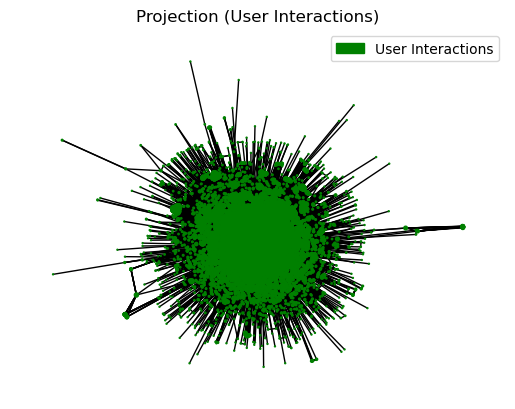

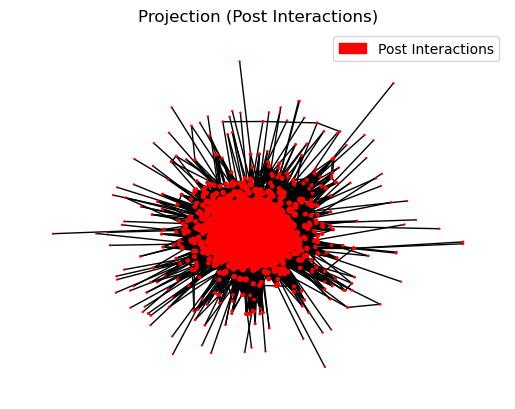

In [3]:
with open('Bipartite_G_5251_cutoff_v3.pkl', 'rb') as f:
    G = pickle.load(f)
# Using the bipartite algorithm the projections of the user and post parts of the graph is done

U, V = bipartite.sets(G)
U_projected = bipartite.projected_graph(G, U)
V_projected = bipartite.projected_graph(G, V)
U_degrees = [U_projected.degree(n) for n in U_projected]
V_degrees = [V_projected.degree(n) for n in V_projected]

scale_factor = 0.5

plt.figure()
plt.title("Projection (User Interactions)")
nx.draw(U_projected, 
        node_color='green', 
        node_size=[d * scale_factor for d in U_degrees], 
        with_labels=False)

green_patch = mpatches.Patch(color='green', label='User Interactions')
plt.legend(handles=[green_patch])

plt.figure()
plt.title("Projection (Post Interactions)")
nx.draw(V_projected, 
        node_color='red', 
        node_size=[d * scale_factor for d in V_degrees], 
        with_labels=False)

red_patch = mpatches.Patch(color='red', label='Post Interactions')
plt.legend(handles=[red_patch])
plt.show()


### Visualisation of the total graph

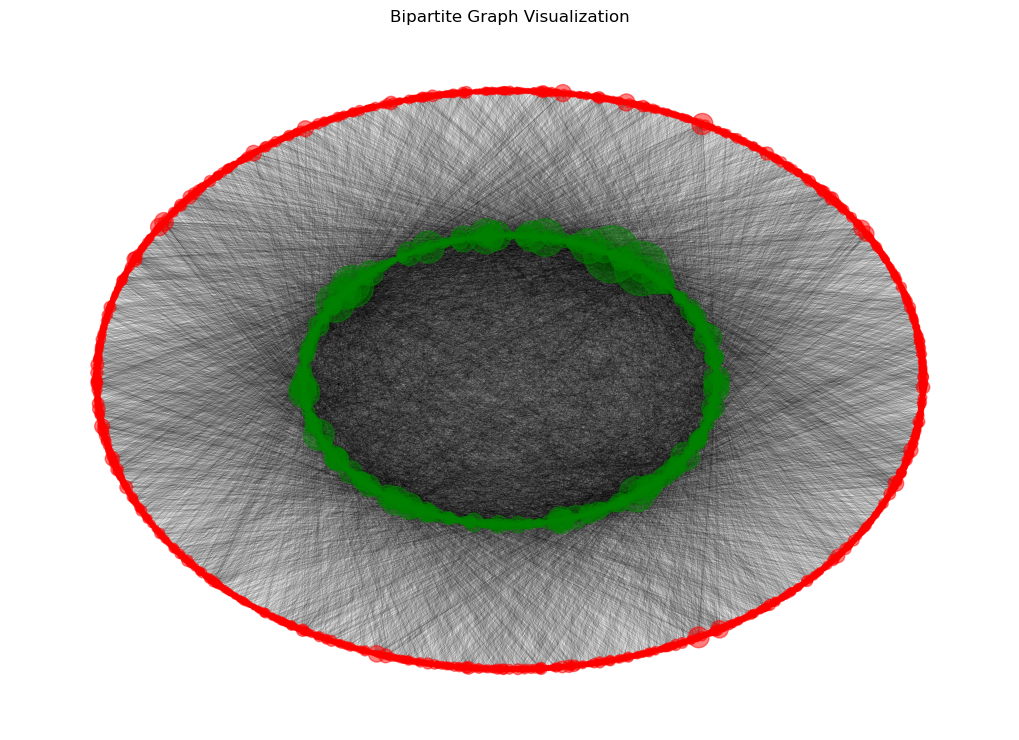

In [4]:
# Plotting function for the bipartite graph:
def plot_bipartite_graph(bipartite_graph):
    # Extract the sets of nodes in each bipartite set
    top_nodes = {n for n, d in bipartite_graph.nodes(data=True) if d['bipartite'] == 0}
    bottom_nodes = set(bipartite_graph) - top_nodes

    # Choose a layout algorithm suitable for bipartite graphs
    # pos = nx.bipartite_layout(bipartite_graph, top_nodes)
    # pos = nx.spring_layout(bipartite_graph, pos=pos, seed=42, dim=2)
    pos = nx.shell_layout(bipartite_graph, nlist=[top_nodes, bottom_nodes])

    # Define colors for nodes in each partition
    colors = ['green' if n in top_nodes else 'red' for n in bipartite_graph.nodes]
    
    # Define sizes for nodes based on their degree
    node_sizes = [2.0 * bipartite_graph.degree[node] for node in bipartite_graph.nodes]

    plt.figure(figsize = (10,7))
    # Plot the bipartite graph with different node colors
    nx.draw(bipartite_graph, pos=pos, with_labels=False, font_weight='bold', node_size=node_sizes, node_color=colors, width = 0.03, alpha=0.5)

    plt.title("Bipartite Graph Visualization")
    plt.show()

plot_bipartite_graph(G)

# Network analysis

### Plotting the degree distributions
Here we simply vizualize the projected graphs degree distrbutions in two histograms with equal axis.

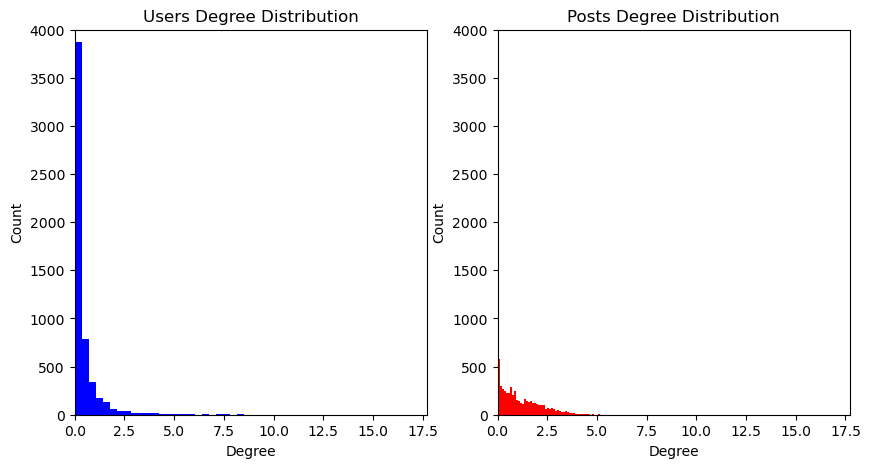

In [14]:
def degree_distribution(t, b, bins = 50):
    
    normalize = lambda x: x / np.std(x)
    
    degree_count_t = normalize(list(dict(nx.degree(t)).values()))
    degree_count_b = normalize(list(dict(nx.degree(b)).values()))
    
    plt.figure(figsize=(10,5))
    plt.tight_layout()
    
    plt.subplot(1, 2, 1)
    plt.hist(degree_count_t, color="b", bins=bins)
    plt.ylim([0,4000])
    plt.xlim([0,max(max(degree_count_t), max(degree_count_b))])
    plt.title("Users Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    
    plt.subplot(1, 2, 2)
    plt.hist(degree_count_b, color="r", bins=bins)
    plt.ylim([0,4000])
    plt.xlim([0,max(max(degree_count_t), max(degree_count_b))])
    plt.title("Posts Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")

    plt.show()
    
degree_distribution(U_projected, V_projected)

### Statistical tests for degree distributuions
In this cell we use the KS statistical test to check wether the degree distributions of degrees are similar to that of a random network. We also check if the degree distributions of the user and post projections are the same. Apart from this we print the average degrees of each graph. 

In [15]:
vals_g = list(dict(nx.degree(G)).values())
vals_u = list(dict(nx.degree(U_projected)).values())
vals_p = list(dict(nx.degree(V_projected)).values())

print("Average degree of full bipartite graph", np.mean(vals_g))
print("Average degree of user projection", np.mean(vals_u))
print("Average degree of post projection", np.mean(vals_p))

def ks_test_for_degrees(dist1, dist2=None):
    if dist2 is None: 
        p = np.mean(dist1) / (len(dist1) - 1)
        ER = nx.erdos_renyi_graph(n=len(dist1), p=p)
        dist2 = list(dict(nx.degree(ER)).values())
    
    dist1 = (dist1 - np.mean(dist1)) / np.std(dist1)
    dist2 = (dist2 - np.mean(dist2)) / np.std(dist2)

    statistic, p_value = ss.ks_2samp(dist1, dist2)
    if p_value < 0.05:
        result = "Reject the null hypothesis: The degree distributions are significantly different."
    else:
        result = "Fail to reject the null hypothesis: No significant difference in degree distributions."

    print(result, p_value)

ks_test_for_degrees(vals_u, vals_p)
ks_test_for_degrees(vals_g)
ks_test_for_degrees(vals_u)
ks_test_for_degrees(vals_p)

Average degree of full bipartite graph 6.048406920676941
Average degree of user projection 49.21806127934062
Average degree of post projection 661.4247397918334
Reject the null hypothesis: The degree distributions are significantly different. 0.0
Reject the null hypothesis: The degree distributions are significantly different. 0.0
Reject the null hypothesis: The degree distributions are significantly different. 2.393473387688604e-236
Reject the null hypothesis: The degree distributions are significantly different. 2.0056298186175922e-32


### Power law analysis of degree distributions
This cell does a simple power law analyzis of the user and post projections. The vizualizations are not included in the main document, but key numbers are referenced.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


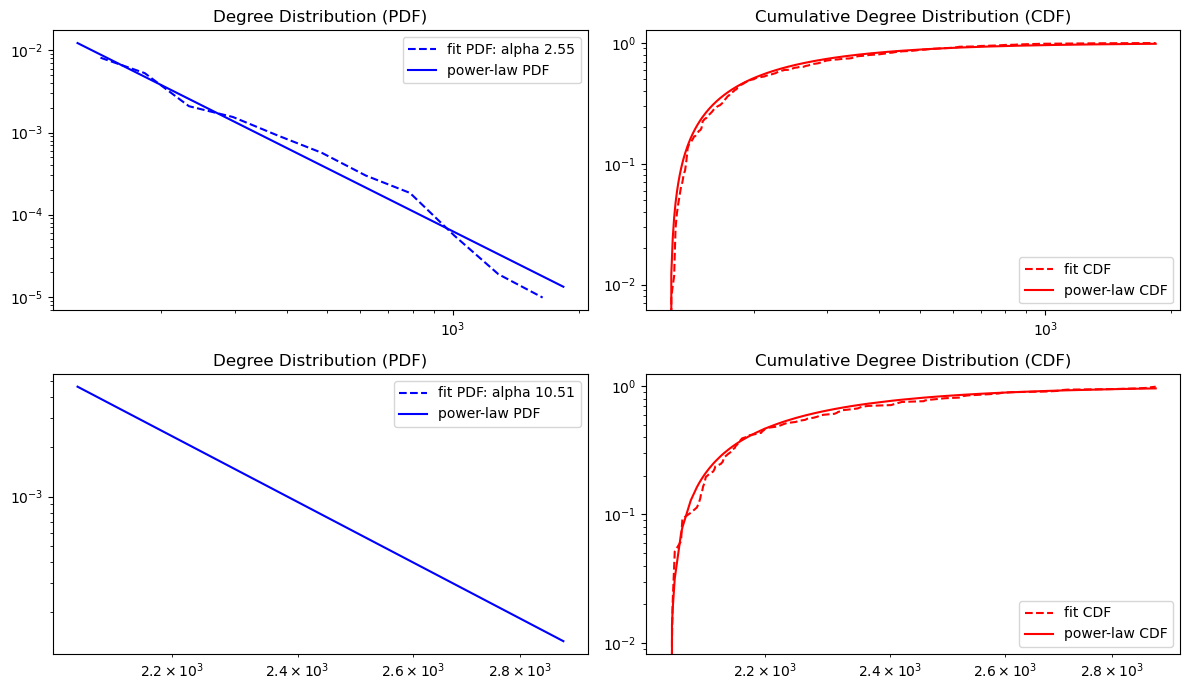

In [17]:
def power_law_analysis(graphs):
    fig, ax = plt.subplots(2, 2, figsize=(12, 7))
    for i, graph in enumerate(graphs):
        # Extract the degree sequence from the graph
        degree_sequence = [d for n, d in graph.degree()]

        # Fit the power-law distribution to the degree sequence
        fit = powerlaw.Fit(degree_sequence)

        fit.plot_pdf(ax=ax[i, 0], color='b', linestyle='--', label='fit PDF: alpha {:.2f}'.format(fit.power_law.alpha))
        fit.power_law.plot_pdf(ax=ax[i, 0], color='b', linestyle='-', label='power-law PDF')

        fit.plot_cdf(ax=ax[i, 1], color='r', linestyle='--', label='fit CDF')
        fit.power_law.plot_cdf(ax=ax[i, 1], color='r', linestyle='-', label='power-law CDF')

        ax[i, 0].set_title('Degree Distribution (PDF)')
        ax[i, 1].set_title('Cumulative Degree Distribution (CDF)')

        for axis in ax[1]:
            axis.legend()
        for axis in ax[0]:
            axis.legend()

    plt.tight_layout()
    plt.show()

power_law_analysis([U_projected,V_projected])

### Centrality analysis of nodes
This cell produces two plots, showing the distributions of closeness centrality for the user and post projections. The vizualizations aren't included in the main document, but key numbers are referenced.

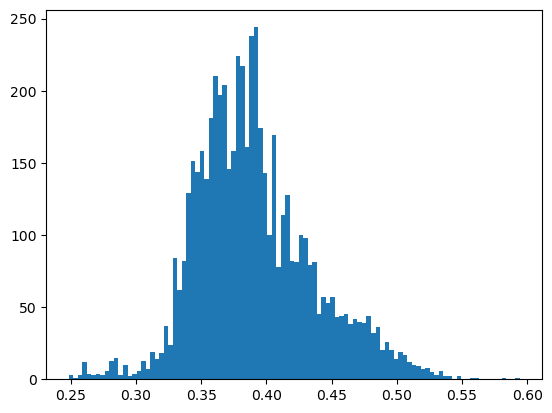

[('Paradise »Lost«', 0.5942492012779552), ('Shagya', 0.5825850908331593), ('£isbeth (Baloo)', 0.5630107960851579), ('Charlotte (Stutteri Lund)', 0.5592303066746843), ('Sine (Aslan)', 0.5476494258514084), ('Camilla (Hesteklip dk)', 0.5463089876639906), ('6 tegn', 0.541905409342527), ('Kirstine *Jenson*', 0.5401219630239086), ('Tina *Turpin*', 0.5379350236190109), ('pony-mor', 0.5361775727875469), ('inger christensen', 0.5354572497840898), ('anja n ♥detvarkattens♥', 0.5352517985611511), ('Sif', 0.5348413687338254), ('Ibh', 0.5345339591914935), ('overskrift', 0.5326968973747017), ('Magnail (Magnetic Nail Design Danmark', 0.5323919473332698), ('varmblod ♥Er vejen frem♥', 0.5310239817282071), ('Stald Lauenborg', 0.5300151975683891), ('Jens Sigurdson', 0.5287595944281247), ('Svar....', 0.5279591257451036), ('lefab98 (Lene Farving)', 0.5271610769957487), ('Praxis', 0.5266635205285513), ('Golda Showers', 0.5265641219212985), ('Lenuccia', 0.5260676911473555), ('Lady Pernille af Glencoe', 0.5248

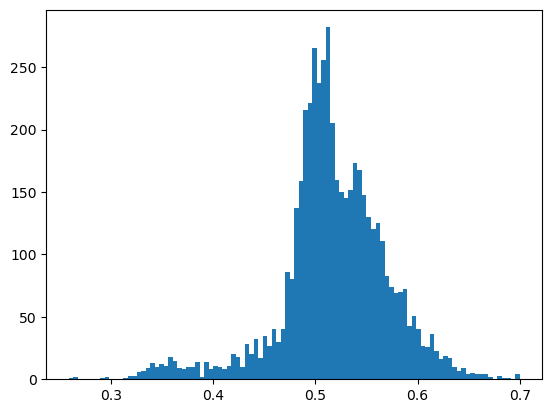

[('/forum/1/2413804/2413804/', 0.7000700770847933), ('/forum/1/2411571/2411571/', 0.698308402069062), ('/forum/1/2397719/2397719/', 0.6967498953828986), ('/forum/1/2427339/2427339/', 0.6959732478751568), ('/forum/1/2396911/2396911/', 0.6909669387190482), ('/forum/1/2395950/2395950/', 0.6825635419513528), ('/forum/1/2408115/2408115/', 0.6804250102165917), ('/forum/1/2415767/2415767/', 0.6804250102165917), ('/forum/1/2414324/2414324/', 0.678391959798995), ('/forum/1/2393539/2393539/', 0.6729085275495083), ('/forum/1/2426718/2426718/', 0.6716417910447762), ('/forum/1/2386817/2386817/', 0.6691225720026792), ('/forum/1/2408488/2408488/', 0.6689433507432704), ('/forum/1/2400857/2400857/', 0.6669782347442916), ('/forum/1/2424375/2424375/', 0.6662665066026411), ('/forum/1/2418387/2418387/', 0.6644938140215512), ('/forum/1/2406950/2406950/', 0.6644938140215512), ('/forum/1/2404239/2404239/', 0.6636110003985651), ('/forum/1/2389227/2389227/', 0.6616770433169956), ('/forum/1/2399704/2399704/', 0.

In [18]:
def centrality_analysis(graph):
    closeness_centrality = nx.closeness_centrality(graph)
    plt.hist(closeness_centrality.values(), bins=100)
    plt.show()
    
    print(sorted(list(closeness_centrality.items()), key=lambda x: x[1], reverse=True))
    print(np.mean(list(closeness_centrality.values())))

centrality_analysis(U_projected)
centrality_analysis(V_projected)

# Sentiment analysis

### Getting the sentiments of each node
This cell defines the functions to calculate sentiments for a graph. The method used is described in the methods section of the main document as "TF;TR". To run this yourself you need the sentiment dictionary from: https://github.com/dsldk/danish-sentiment-lexicon

In [ ]:
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
da_stop = set(nltk.corpus.stopwords.words('danish'))

sent_df = pd.read_csv("sentiment_analysis/2_headword_headword_polarity.csv", header=None)[[0, 4]]
sentiment_dict = {row[0]: row[4] for _, row in sent_df.iterrows()}

def get_tfs(text):
    return dict(nltk.probability.FreqDist(([lemmatizer.lemmatize(w) for word in text if (w:=word.lower()).isalpha()])))

# Use this function to find sentiments of node attributes
def get_sents(node_att):
    post_sents = dict()
    for post_id, text in tqdm(node_att.items()):
        tf = get_tfs(nltk.word_tokenize(text))
        if (denom := np.sum([tf[word] for word in tf.keys() if word in list(sentiment_dict.keys())])) != 0 :
            post_sents[post_id] = (
                np.sum([sentiment_dict[word] * tf[word] for word in tf.keys() if word in list(sentiment_dict.keys())]) / 
                denom
            )
        else:
            post_sents[post_id] = 0
    
    return post_sents

### Adding the sentiments as node attributes

Using the sentiment function we built, we then calculate the sentiment for all nodes, be it post or user, and then add their final sentiment values back into the repsective nodes.

In [ ]:
# extract all posts from graph
texts = nx.get_node_attributes(G, 'text')

# Compute sentiment scores for each node
sentiment_scores = get_sents(texts)

# Feed sentiment scores back into the nodes of the graph
for node, sentiment in sentiment_scores.items():
    # Check if the node exists to be extra cautious, though this should always be true
    if G.has_node(node):
        nx.set_node_attributes(G, {node: sentiment}, 'sentiment')

with open(f'Bipartite_G_5251_cutoff_v3_with_sentiments.pkl', 'wb') as f:
    pickle.dump(G, f)

100%|██████████| 10577/10577 [10:54<00:00, 16.17it/s] 


### Plotting sentiment distributions

Now having the sentiments in each node, allows us to compare the 2 projections of the bipartite graph in relation to the distribution of their sentiments. We do so as well as adding summary statistic to better quantify their differences.

Average Sentiment for Users: 0.7073538199128669
Median Sentiment for Users: 0.7055427251732102
Q1 Sentiment for Users: 0.0
Q3 Sentiment for Users: 1.2083333333333333
Average Sentiment for Posts: 0.7976489567573478
Median Sentiment for Posts: 0.7916666666666666
Q1 Sentiment for Posts: 0.42847985347985346
Q3 Sentiment for Posts: 1.1818181818181819


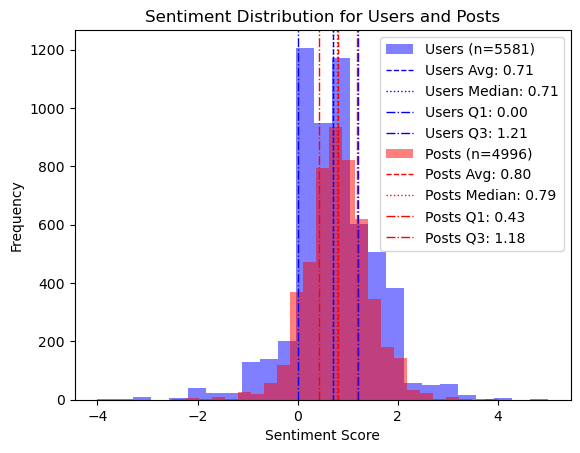

In [20]:
with open('Bipartite_G_5251_cutoff_v3_with_sentiments.pkl', 'rb') as f:
    G = pickle.load(f)

sentiment_scores = nx.get_node_attributes(G,'sentiment')

U, V = bipartite.sets(G)
U_projected = bipartite.projected_graph(G, U)
V_projected = bipartite.projected_graph(G, V)

user_graph = U_projected
post_graph = V_projected
def plot_sentiment_distribution(sentiments, category, color,full_measure=True):
    """Plots the sentiment distribution and its statistical measures."""
    avg = np.mean(sentiments)
    median = np.median(sentiments)
    q1 = np.percentile(sentiments, 25)
    q3 = np.percentile(sentiments, 75)

    plt.hist(sentiments, bins=25, alpha=0.5, color=color, label=f'{category} (n={len(sentiments)})')
    plt.axvline(avg, color=color, linestyle='dashed', linewidth=1, label=f'{category} Avg: {avg:.2f}')
    if full_measure:
        plt.axvline(median, color=color, linestyle='dotted', linewidth=1, label=f'{category} Median: {median:.2f}')
        plt.axvline(q1, color=color, linestyle='dashdot', linewidth=1, label=f'{category} Q1: {q1:.2f}')
        plt.axvline(q3, color=color, linestyle='dashdot', linewidth=1, label=f'{category} Q3: {q3:.2f}')

    # Print statistical measures
    print(f"Average Sentiment for {category}:", avg)
    if full_measure:
        print(f"Median Sentiment for {category}:", median)
        print(f"Q1 Sentiment for {category}:", q1)
        print(f"Q3 Sentiment for {category}:", q3)

# Assuming G is your graph and sentiment_scores is a dictionary with sentiments
node_att = nx.get_node_attributes(G, 'bipartite')

# Separating sentiment scores for users and posts
user_sents = [sentiment for node, sentiment in sentiment_scores.items() if node_att[node] == 0]
post_sents = [sentiment for node, sentiment in sentiment_scores.items() if node_att[node] == 1]

# Plotting
plot_sentiment_distribution(user_sents, 'Users', 'blue')
plot_sentiment_distribution(post_sents, 'Posts', 'red')

plt.legend()
plt.title('Sentiment Distribution for Users and Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


### Statistical tests for sentiment distributions

Using the label reshuffeling method we also test wheter there is a significant diffnerence in the sentiment of users and posts, and test for 10.000 shuffles.

In [21]:
actual_user_mean = np.mean(user_sents)
actual_post_mean = np.mean(post_sents)
n_simulations = 10000

count = 0

for _ in range(n_simulations):
    shuffled_sentiments = np.random.permutation(np.concatenate((user_sents, post_sents)))
    shuffled_user = shuffled_sentiments[:len(user_sents)]
    shuffled_post = shuffled_sentiments[len(user_sents):]
    
    shuffled_user_mean = np.mean(shuffled_user)
    shuffled_post_mean = np.mean(shuffled_post)
    
    if abs(shuffled_user_mean - actual_user_mean) >= abs(shuffled_post_mean - actual_post_mean):
        count += 1

p_value = count / n_simulations

if p_value < 0.05:
    result = "Reject the null hypothesis: There is a significant difference in sentiment between users and posts."
else:
    result = "Fail to reject the null hypothesis: No significant difference in sentiment."

result, p_value

('Reject the null hypothesis: There is a significant difference in sentiment between users and posts.',
 0.0)

We also test using a normal t-test, as we apply CLT to approximate a normal distribtion.

In [31]:
print(ss.ttest_ind(user_sents,post_sents))

TtestResult(statistic=-6.126735741227783, pvalue=9.289384929306135e-10, df=10575.0)


# Communities


As also descriped in the report, we mostly use the Louvain algorithm to partition our graphs into communities. 

### Partitioning based on tags

However we also test how the modularity of partitioning on subject tags:

In [22]:
# Partitioning of post projection using tags.
attribute = 'tag'  
partition = {node: data[attribute] for node, data in post_graph.nodes(data=True)}
modularity = community_louvain.modularity(partition, post_graph)
print("Modularity of the partition based on attribute: ", modularity)



Modularity of the partition based on attribute:  0.00605774908507099


### Modularity of each tag community

As well as identifing the modularity within each subject tag. However we never use this in the report

In [23]:
unique_tags = set(nx.get_node_attributes(post_graph, attribute).values())
subgraphs = {tag: post_graph.subgraph([n for n, d in post_graph.nodes(data=True) if d.get(attribute) == tag]) for tag in unique_tags}

for tag, subgraph in subgraphs.items():
    if len(subgraph.nodes()) > 0:
        sub_partition = community_louvain.best_partition(subgraph)
        sub_modularity = community_louvain.modularity(sub_partition, subgraph)
        print(f"Modularity within '{tag}' tag: {sub_modularity}")
    else:
        print(f"No nodes with '{tag}' tag.")

Modularity within 'OT' tag: 0.24833235056423417
Modularity within 'VITT' tag: 0.25769490404715645
Modularity within 'NYHED' tag: 0.3637466668834548
Modularity within 'KULT' tag: 0.2890293022876034
Modularity within 'MAD' tag: 0.20414519638367976
Modularity within 'HEST' tag: 0.24302375651282376
Modularity within 'UDDA' tag: 0.3170447284277165
Modularity within 'VELF' tag: 0.20048236827727667


### Partitioning users and posts seperately

Lastly we actually use Louvain and find some quite nice modularities.

In [24]:
best_user_partition = community_louvain.best_partition(user_graph)
best_post_partition = community_louvain.best_partition(post_graph)
best_user_mod = community_louvain.modularity(best_user_partition,user_graph)
best_post_mod = community_louvain.modularity(best_post_partition,post_graph)
number_of_user_partitions = len(set(best_user_partition.values()))
number_of_post_partitions = len(set(best_post_partition.values()))
print(f"Modularity of user partitions: {best_user_mod}, with {number_of_user_partitions} communities")
print(f"Modularity of post partitions: {best_post_mod}, with {number_of_post_partitions} communities")


Modularity of user partitions: 0.40252854940532146, with 22 communities
Modularity of post partitions: 0.23374473884570496, with 5 communities


### Visualising users and posts with community partitions

This is NOT used in the report and is a simple attempt at showing that the visulization of the communities are not beneficial for understanding them.

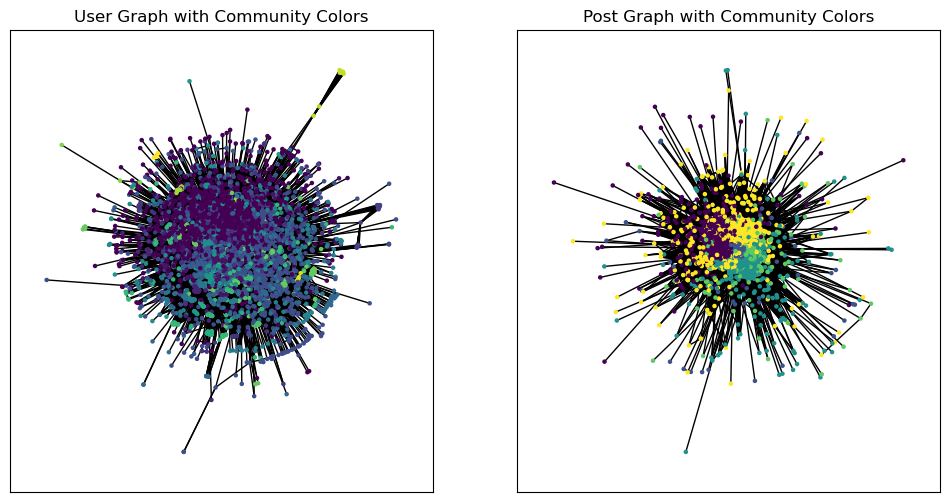

In [25]:
plt.figure(figsize=(12, 6))
size = 5
plt.subplot(1, 2, 1)
pos = nx.spring_layout(user_graph)  
user_colors = [best_user_partition[node] for node in user_graph]
nx.draw_networkx(user_graph, pos, node_color=user_colors, with_labels=False, node_size = size)
plt.title('User Graph with Community Colors')

plt.subplot(1, 2, 2)
pos = nx.spring_layout(post_graph)  
post_colors = [best_post_partition[node] for node in post_graph]
nx.draw_networkx(post_graph, pos, node_color=post_colors, with_labels=False, node_size = size)
plt.title('Post Graph with Community Colors')

plt.show()

### Plotting sentiment distribution for post community partitions

Then using the parition of posts, we plot their sentiment distributions and means to determine their differences.

Average Sentiment for Community 0: 0.8179437009837452
Average Sentiment for Community 1: 0.7105059516926429
Average Sentiment for Community 4: 0.7811805416575047
Average Sentiment for Community 3: 0.8259051305160028
Average Sentiment for Community 2: 0.8367934368910237


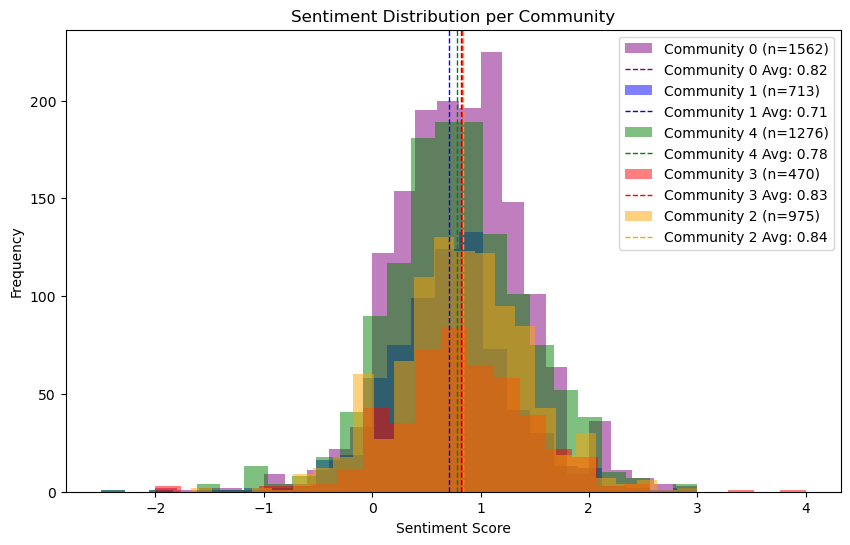

In [26]:
color = ['purple', 'blue', 'green', 'red','orange']
# Extracting sentiments from nodes and grouping by community
community_sentiments = {}
for node, data in post_graph.nodes(data=True):
    community = best_post_partition[node]
    sentiment = data['sentiment']  # Replace 'sentiment' with the actual attribute key
    community_sentiments.setdefault(community, []).append(sentiment)

# Plotting histograms
plt.figure(figsize=(10, 6))
for idx, (community, sentiment_scores) in enumerate(community_sentiments.items()):
    plot_sentiment_distribution(sentiment_scores,f'Community {community}',color[idx],full_measure=False)
    # plt.hist(sentiment_scores, bins=20, alpha=0.5, label=f'Community {community}')

plt.title('Sentiment Distribution per Community')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Modularity based on time

Another comparison was checking wheter paritioning on time would give nice modularity. Here we attempt to split the interval of time between the first and last post of our data into n=1..20 partitions using datetime ranges.

In [27]:
timedates = [data['timestamp'] for _, data in post_graph.nodes(data=True)]
min_time = min(timedates)
max_time = max(timedates)

# Convert timedates to a comparable format (e.g., timestamps)
timestamps = [td for td in timedates]
min_timestamp = min(timestamps)
max_timestamp = max(timestamps)
time_range = max_timestamp - min_timestamp

modularity_scores = []

# Iterate over different numbers of splits (4 to 20)
for n_splits in range(1, 21):
    # Determine the time range for each community
    split_duration = time_range / n_splits

    # Assigning nodes to communities based on timedate
    partition = {}
    for node, data in post_graph.nodes(data=True):
        timedate = data['timestamp']
        community = int((timedate - min_timestamp) / split_duration)
        partition[node] = community
    
    # Calculating modularity
    communities = list(set(partition.values()))
    modularity = community_louvain.modularity(partition,post_graph)
    modularity_scores.append((n_splits, modularity))

sorted(modularity_scores,key=lambda x:x[1],reverse=True)

[(8, 0.07231991169274847),
 (7, 0.07230435648292625),
 (9, 0.07087068837519417),
 (6, 0.0680913024313269),
 (4, 0.0661125657548633),
 (5, 0.06587072968728054),
 (10, 0.06465480936589736),
 (11, 0.05659702371117615),
 (3, 0.0549235605777792),
 (12, 0.05364112911014619),
 (13, 0.048870134578417816),
 (14, 0.04629801689806594),
 (15, 0.045953031697919346),
 (16, 0.04313417072889562),
 (17, 0.04236737680229001),
 (18, 0.042031474751564504),
 (19, 0.039651444495525004),
 (20, 0.038035098642281),
 (2, 0.03149807622700242),
 (1, 0.0008576667260877615)]

### Visualising sentiments of user community partitions

Like with the posts, we attempt to plot and show the difference in sentiments of users, but with 22 communities it becomes unreadable and is not used for the report.

Average Sentiment for Community 0: 0.7392631528783986
Average Sentiment for Community 1: 0.5526437323028378
Average Sentiment for Community 2: 0.7585169386948013
Average Sentiment for Community 3: 0.5718672293412213
Average Sentiment for Community 16: 0.5868169078977731
Average Sentiment for Community 5: 0.7681365290162097
Average Sentiment for Community 6: 0.4881258940404821
Average Sentiment for Community 7: 0.7842028806730718
Average Sentiment for Community 8: 0.5636224422716677
Average Sentiment for Community 9: 0.7432851901254574
Average Sentiment for Community 10: 0.7743670487234665
Average Sentiment for Community 11: 0.9549845919534474
Average Sentiment for Community 12: 1.5
Average Sentiment for Community 13: 0.5545140162996005
Average Sentiment for Community 14: 0.5941914945630619
Average Sentiment for Community 17: 0.5
Average Sentiment for Community 18: 0.5735093167701864
Average Sentiment for Community 19: 0.6871794871794872
Average Sentiment for Community 20: 0.68301282051

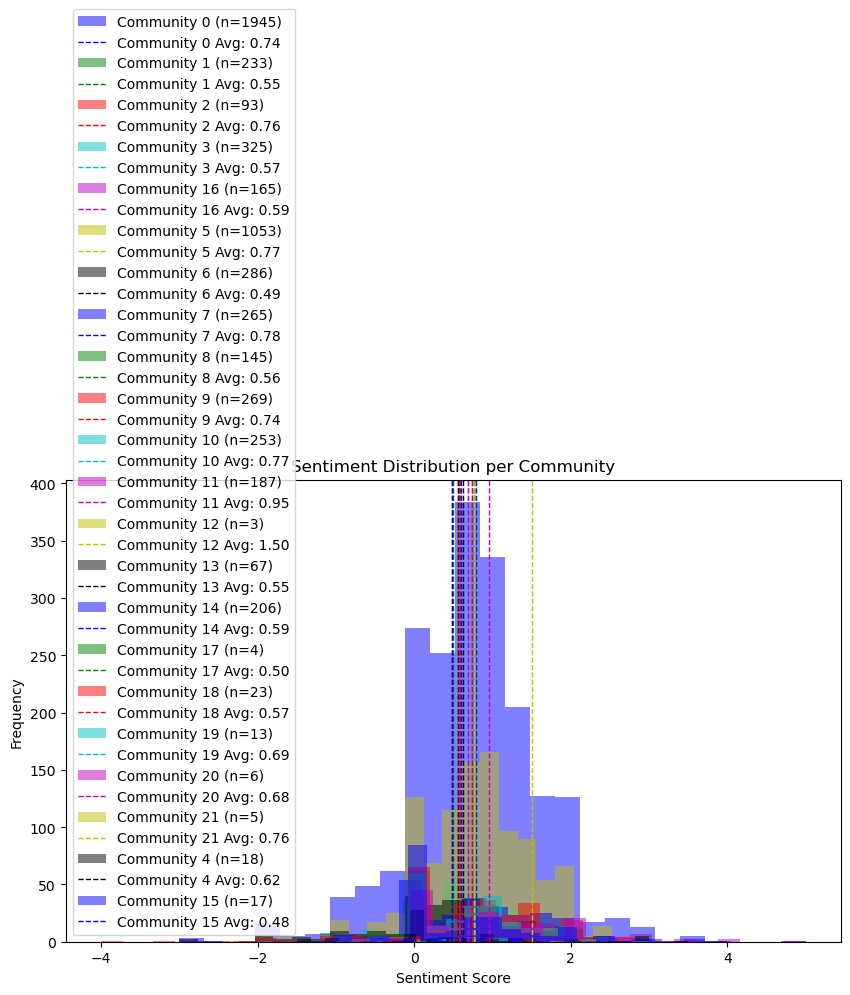

In [29]:
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']*4
# Extracting sentiments from nodes and grouping by community
community_sentiments = {}
for node, data in user_graph.nodes(data=True):
    community = best_user_partition[node]
    sentiment = data['sentiment']  # Replace 'sentiment' with the actual attribute key
    community_sentiments.setdefault(community, []).append(sentiment)

# Plotting histograms
plt.figure(figsize=(10, 6))
for idx, (community, sentiment_scores) in enumerate(community_sentiments.items()):
    plot_sentiment_distribution(sentiment_scores,f'Community {community}',color[idx],full_measure=False)
    # plt.hist(sentiment_scores, bins=20, alpha=0.5, label=f'Community {community}')

plt.title('Sentiment Distribution per Community')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Finally we instead represent the above data as a latex table:

In [30]:
community_sentiments = {}
for node, data in user_graph.nodes(data=True):
    community = best_user_partition[node]
    sentiment = data['sentiment']  # Replace 'sentiment' with the actual attribute key
    community_sentiments.setdefault(community, []).append(sentiment)

# Calculating community sizes and average sentiments
community_data = {
    'Community': [],
    'Size': [],
    'Average Sentiment': []
}
for community, sentiments in community_sentiments.items():
    community_data['Community'].append(community)
    community_data['Size'].append(len(sentiments))
    community_data['Average Sentiment'].append(sum(sentiments) / len(sentiments))

# Creating a DataFrame for the LaTeX table
df = pd.DataFrame(community_data)

df_sorted = df.sort_values(by='Community', ascending=True)
latex_table = df_sorted.to_latex(index=False)

print(latex_table)

\begin{tabular}{rrr}
\toprule
Community & Size & Average Sentiment \\
\midrule
0 & 1945 & 0.739263 \\
1 & 233 & 0.552644 \\
2 & 93 & 0.758517 \\
3 & 325 & 0.571867 \\
4 & 18 & 0.622952 \\
5 & 1053 & 0.768137 \\
6 & 286 & 0.488126 \\
7 & 265 & 0.784203 \\
8 & 145 & 0.563622 \\
9 & 269 & 0.743285 \\
10 & 253 & 0.774367 \\
11 & 187 & 0.954985 \\
12 & 3 & 1.500000 \\
13 & 67 & 0.554514 \\
14 & 206 & 0.594191 \\
15 & 17 & 0.480147 \\
16 & 165 & 0.586817 \\
17 & 4 & 0.500000 \\
18 & 23 & 0.573509 \\
19 & 13 & 0.687179 \\
20 & 6 & 0.683013 \\
21 & 5 & 0.760000 \\
\bottomrule
\end{tabular}

